This notebook generates the deprojected radius plot, MaNGA H$\alpha$ velocity map, and image cut-out of a single SGA galaxy.

In [1]:
import os
import requests

import numpy as np
import numpy.ma as ma

from astropy.io import fits
from astropy.table import Table
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA')
from plot_funcs import plot_radec_DESI
sys.path.insert(2, '/global/u1/k/kadglass/RotationCurves/spirals')
from DRP_rotation_curve import extract_data
from DRP_rotation_curve_plottingFunctions import plot_vel
from DRP_vel_map_functions import deproject_spaxel
from dark_matter_mass_v1 import rot_fit_BB

In [2]:
mpl.rc('font', size=12)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h

c = const.c

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Import data

## DESI PV

In [4]:
#tf_targets = Table.read('../TF/cache/tf_targets_everest.fits')
#tf_targets = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') <-- CORI
tf_targets = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

## SGA

In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [6]:
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## SDSS MaNGA cross-match file

In [7]:
SGA_MaNGA = Table.read('MaNGA_DESI_galaxies_08042021.txt', format='ascii.commented_header')

In [8]:
SGA_MaNGA[:5]

MaNGA_plate,MaNGA_IFU,sga_id,BA,PA,plateifu
int64,int64,int64,float64,float64,str10
7968,3702,97758,0.3215293288230896,159.22218322753906,7968-3702
8479,6101,433955,0.32715362310409546,54.33457565307617,8479-6101
8479,6102,487085,0.5813088417053223,1.3182913064956665,8479-6102
8480,6103,487085,0.5813088417053223,1.3182913064956665,8480-6103
8481,12705,810971,0.268082857131958,56.5462760925293,8481-12705


## MaNGA fits

In [9]:
#MaNGA_fits = Table.read('DESI_vel_map_results_BB_smooth_lt_1p85_v2.txt', 
#MaNGA_fits = Table.read('DESI_vel_map_results_BB_smooth_lt_1p85_v1.txt', 
#MaNGA_fits = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_H2_noWords_v7.txt', 
MaNGA_fits = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_H2_noWords_v8.txt', 
                        format='ascii.commented_header')

## Extract data for desired galaxy

Two options: Extract via MaNGA plate-IFU, or by SGA (galaxy name)

In [1183]:
gal_id = '9876-9102'

plate, IFU = gal_id.split('-')

SGA_MaNGA_idx = (SGA_MaNGA['MaNGA_plate'] == int(plate)) & (SGA_MaNGA['MaNGA_IFU'] == int(IFU))
#MaNGA_idx = MaNGA_fits['plateifu'] == gal_id
MaNGA_idx = (MaNGA_fits['MaNGA_plate'] == int(plate)) & (MaNGA_fits['MaNGA_IFU'] == int(IFU))
sga_id = SGA_MaNGA['sga_id'][SGA_MaNGA_idx][0]
SGA_idx = SGA['SGA_ID'] == sga_id

PV_indices = tf_targets['SGA_ID'] == sga_id

In [1184]:
'''
gal_name = 'UGC10615'

SGA_idx = SGA['GALAXY'] == gal_name

sga_id = SGA['SGA_ID'][SGA_idx][0]

SGA_MaNGA_idx = SGA_MaNGA['sga_id'] == sga_id

gal_id = SGA_MaNGA['plateifu'][SGA_MaNGA_idx][0]

plate, IFU = gal_id.split('-')

MaNGA_idx = MaNGA_fits['plateifu'] == gal_id

PV_indices = tf_targets['SGA_ID'] == sga_id
''';

In [1185]:
gal_PV_obs = tf_targets[PV_indices]

SGA_info = SGA[SGA_idx]

MaNGA_fit = MaNGA_fits[MaNGA_idx]

MaNGA_fit

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,Tidal,GZ_edge_on,GZ_bar,GZ_spiral,DL_ttype,DL_s0,DL_edge_on,DL_bar_GZ2,DL_bar_N10,DL_merge,map_frac_unmasked,SFR,sSFR,Rmax_map,NSA_elpetro_th50,sigma,SK,R50_kpc,R90_kpc,Mdyn50_SK,Mdyn90_SK,logH2,logH2_err,H2_source
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
9876,9102,2242,362,54153,483375,195.855551,28.014011,0.521491,42.972046,0.026544,11614543872.0,0.0,2165.91883,1.0,0.184247,1.780538,88.034113,510.957501,10.43785,4.022996,0.275592,395.669976,718.361408,14775.33089,0.419152,67.101947,1543.07076,0.118983,0.001981,5470468843541.284,5052903087.306595,5452719936878.753,5052903087.306595,17748906662.530952,307.214413,0.284688,-19.626022,0.003352,0.414762,2.361593,0.085501,0.001,0.982363,-99.0,-99.0,2.0,-99,0,8.803411,39.566998,154.307076,2229573,-99.0,2.339831,0.090798,5.01535,308.214413,0.284688,2.650709,499.708054,602.032393,-495.959707,0.700253,0.005006,239.672791,0.326658,9.023446,26.2875,30.84066,5.517662,30.939424,5.669432,314.624423,63.308625,99.502576,101.616248,7.997736,0.735566,13.003702,12.318382,846.328315,12.345255,1.663827,0.018607,10.11996,11.206493,2.601287,16.531834,155.073964,5341124.8153,-999.0,-1147.153167,-1147.153167,2,-1.0,0,0.083333,0.939394,0.424242,4.052434,0.965367,0.000687,0.941344,0.534456,0.256656,0.45166,-1.323358,-11.665454,7.756759,6.849174,130.26484,4738603.531586,2.642385,6.377918,5240329873077.302,12648571583099.055,-99.0,-99.0,0


In [1186]:
ba = SGA_MaNGA['BA'][SGA_MaNGA_idx][0]
cosi = np.sqrt((ba**2 - q0**2)/(1 - q0**2))
i_angle = np.arccos(cosi)
#i_angle = np.arccos(ba)
#print(i_angle*180/np.pi, np.arccos(ba)*180/np.pi)

phi = SGA_MaNGA['PA'][SGA_MaNGA_idx][0] + 180

r26 = 0.5*SGA_info['D26'][0]*u.arcmin
scale_r26 = MANGA_SPAXEL_SIZE/r26.to('arcsec') #spaxels to R26

# MaNGA rotation curve best-fit parameters
'''
x0 = MaNGA_fit['x0'][0]
y0 = MaNGA_fit['y0'][0]
v_sys = MaNGA_fit['v_sys'][0]
R_turn = MaNGA_fit['r_turn'][0]
V_max = MaNGA_fit['v_max'][0]
alpha = MaNGA_fit['alpha'][0]
''';
x0 = MaNGA_fit['x0_map'][0]
y0 = MaNGA_fit['y0_map'][0]
v_sys = MaNGA_fit['Vsys_map'][0]
R_turn = MaNGA_fit['Rturn_map'][0]
V_max = MaNGA_fit['Vmax_map'][0]
alpha = MaNGA_fit['alpha_map'][0]

gal_PV_obs

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
2305843020093722889,195.855529187551,28.0139984065702,10379,sv3,0.0265658181291536,2.38921205739697e-05,0,1912.81642458912,fuji/healpix/sv3/backup/103/10379/redrock-sv3-backup-10379.fits,SGA,200961,195.85553786108392,28.013972754820852
39628438633447988,195.855537861084,28.0139727548209,10379,sv3,0.026578874628517,1.06656710385456e-05,0,10606.5532011734,fuji/healpix/sv3/bright/103/10379/redrock-sv3-bright-10379.fits,SGA,200961,195.85553786108392,28.013972754820852


In [1187]:
SGA_info

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
200961,SGA-2020 200961,PGC093700,93700,195.85548000000003,28.0140266,SBbc,38.79,0.5821032,0.60394865,0.026544029,23.53848,16.085,False,LEDA-20181114,72079,PGC093700,1,True,195.85548000000003,28.0140266,0.5821032,1959p280,195.85553786108392,28.013972754820852,0.9824905,SB26,37.56478,0.59416074,195.85550477487627,28.01405032428538,20.917667,7.33972,7.311367,7.2676997,9.107525,11.268477,13.500703,15.724952,17.966179,20.441622,23.068611,26.345797,29.474714,16.171255,15.452208,14.918577,16.008873,15.291121,14.760582,15.893514,15.176201,14.648266,15.81431,15.097924,14.57125,15.760143,15.0436735,14.51779,15.72143,15.005196,14.478592,15.692876,14.978106,14.4501,15.667337,14.952761,14.423989,15.651581,14.935435,14.407768,0.044314407,0.07213172,0.0756886,0.09419829,0.08782103,0.12007273,0.12887496,0.11888476,0.13976833,0.010753037,0.009625117,0.012797511,0.009928325,0.00898967,0.011586931,0.009319373,0.008514677,0.010782495,0.008866428,0.008141161,0.010227544,0.008544177,0.0078609865,0.009835388,0.008300605,0.007639271,0.009538718,0.008111865,0.0074780355,0.00931981,0.007941201,0.0073237526,0.009118307,0.007837404,0.007217612,0.008996752,15.609309,0.37336946,2.6862526,2.8598106,0.09277428,14.893538,0.3793823,2.584065,2.8303254,0.21976212,14.360931,0.38968837,2.4696836,2.727638,0.049596354,0


### MaNGA maps

In [1188]:
#MANGA_FOLDER = '/project/projectdirs/sdss/data/sdss/dr16/manga/spectro/'
MANGA_FOLDER = '/global/cfs/projectdirs/sdss/data/sdss/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

MaNGA_maps = extract_data(VEL_MAP_FOLDER, gal_id, ['Ha_vel', 'Ha_flux'])

### Hessian (from best-fit to MaNGA data)

In [1189]:
Hessian = np.load('DRP_map_Hessians/' + gal_id + '_Hessian.npy')

hess_inv = 2*np.linalg.inv(Hessian)

# Calculate DESI data points

## Calculate the distance between the SGA galaxy center and each observation

In [1190]:
SGA_coords = SkyCoord(ra=SGA_info['RA'], dec=SGA_info['DEC'], unit=u.degree)
target_coords = SkyCoord(ra=gal_PV_obs['RA'], dec=gal_PV_obs['DEC'], unit=u.degree)
#target_coords = SkyCoord(ra=gal_PV_obs['FIBER_RA'], dec=gal_PV_obs['FIBER_DEC'], unit=u.degree)

sep2d = target_coords.separation(SGA_coords)

gal_PV_obs['SKY_FIBER_DIST'] = sep2d
gal_PV_obs['SKY_FIBER_DIST_R26'] = sep2d.to('arcmin')/r26

gal_PV_obs

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
,,,,,,,,,,,,,,deg,
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,float64,float64
2305843020093722889,195.855529187551,28.0139984065702,10379,sv3,0.0265658181291536,2.38921205739697e-05,0,1912.81642458912,fuji/healpix/sv3/backup/103/10379/redrock-sv3-backup-10379.fits,SGA,200961,195.85553786108392,28.013972754820852,0.0,0.0
39628438633447988,195.855537861084,28.0139727548209,10379,sv3,0.026578874628517,1.06656710385456e-05,0,10606.5532011734,fuji/healpix/sv3/bright/103/10379/redrock-sv3-bright-10379.fits,SGA,200961,195.85553786108392,28.013972754820852,0.0,0.0


## Calculate the rotational velocities

If there is more than one observation of the galactic center, use the average redshift for the center redshift.

In [1191]:
'''
# Remove observations that RedRock fit as a STAR
stars = gal_PV_obs['SPECTYPE'] == 'STAR'
gal_PV_obs_gal = gal_PV_obs[~stars]
''';

is_sga_center = (gal_PV_obs['TARGETID'] > 30000000000000000) & (gal_PV_obs['TARGETID'] < 40000000000000000)

z_center = np.mean(gal_PV_obs['Z'][is_sga_center])
z_center_err = np.sqrt(np.sum((gal_PV_obs['Z'][is_sga_center]/np.sum(is_sga_center))**2 * gal_PV_obs['ZERR'][is_sga_center]**2))

dz = np.abs(gal_PV_obs['Z'] - z_center)
dz_err = np.sqrt(gal_PV_obs['ZERR']**2 + z_center_err**2)

gal_PV_obs['V'] = dz*c.to('km/s')
gal_PV_obs['VERR'] = dz_err*c.to('km/s')


#---------------------------------------------------------------------------
# Correct velocities for inclination angle
#---------------------------------------------------------------------------
cosi2 = (SGA_info['BA'][0]**2 - q0**2)/(1 - q0**2)

# Galaxies with b/a < q0
if cosi2 < 0:
    cosi2 = 0
    
gal_PV_obs['V'] /= np.sin(np.arccos(np.sqrt(cosi2)))
#---------------------------------------------------------------------------


#---------------------------------------------------------------------------
# Remove observations that do not have good redshifts (Vrot > 1000 km/s)
#---------------------------------------------------------------------------
good_v = gal_PV_obs['V'] < 1000

gal_PV_obs_good = gal_PV_obs[good_v]
#---------------------------------------------------------------------------

gal_PV_obs_good

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,V,VERR
,,,,,,,,,,,,,,deg,,km / s,km / s
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,float64,float64,float64,float64
2305843020093722889,195.855529187551,28.0139984065702,10379,sv3,0.0265658181291536,2.38921205739697e-05,0,1912.81642458912,fuji/healpix/sv3/backup/103/10379/redrock-sv3-backup-10379.fits,SGA,200961,195.85553786108392,28.013972754820852,0.0,0.0,4.768041054683386,7.163181715892047
39628438633447988,195.855537861084,28.0139727548209,10379,sv3,0.026578874628517,1.06656710385456e-05,0,10606.5532011734,fuji/healpix/sv3/bright/103/10379/redrock-sv3-bright-10379.fits,SGA,200961,195.85553786108392,28.013972754820852,0.0,0.0,0.0,3.1986169486162312


## Calculate distance to galaxy

In [1192]:
distance = z_center*c.to('km/s')/(H0*u.km/u.s/u.Mpc)
#distance = 0.0256367*c.to('km/s')/(H0*u.km/u.s/u.Mpc) # redshift from NSA
#distance_kpc = distance_Mpc*1000
scale = distance.to('kpc')*np.tan(r26.to('radian')) #R26 to kpc
#scale = distance.to('kpc')*np.tan(MANGA_SPAXEL_SIZE.to('radian'))
scale_kpc = scale.value

# Deproject MaNGA spaxels

## Mask velocity map

In [1193]:
SN = MaNGA_maps['Ha_flux']*np.sqrt(MaNGA_maps['Ha_flux_ivar'])

map_mask = MaNGA_maps['Ha_vel_mask'] + MaNGA_maps['Ha_flux_mask'] + (SN < 5)

mHa_vel = ma.array(MaNGA_maps['Ha_vel'], mask=map_mask)
mHa_vel_ivar = ma.array(MaNGA_maps['Ha_vel_ivar'], mask=map_mask)

## Deproject spaxels

In [1194]:
vel_array_shape = mHa_vel.shape

r_deproj = np.zeros(vel_array_shape)
v_deproj = np.zeros(vel_array_shape)

theta = np.zeros(vel_array_shape)

for i in range(vel_array_shape[0]):
    for j in range(vel_array_shape[1]):
        
        r_deproj[i,j], theta[i,j] = deproject_spaxel((i,j), 
                                                     (x0, y0), 
                                                     phi*np.pi/180, 
                                                     i_angle)

# Scale radii to convert from spaxels to R26
r_deproj *= scale_r26.value
#r_deproj *= (distance.to('kpc')*np.tan(MANGA_SPAXEL_SIZE.to('radian'))).value

# Deproject velocity values
v_deproj = (mHa_vel - v_sys)/np.abs(np.cos(theta))
v_deproj /= np.sqrt(1 - cosi**2)
#v_deproj /= np.sin(i_angle)

# Apply masks to arrays
rm_deproj = ma.array(r_deproj, mask=mHa_vel.mask)
vm_deproj = ma.array(v_deproj, mask=mHa_vel.mask)

# Plot data

## H$\alpha$ velocity map

In [1195]:
'''
plot_vel(mHa_vel, 
         gal_id, 
         IMAGE_DIR='../Figures/', 
         FOLDER_NAME='',
         FILENAME_SUFFIX='_Ha_map.'
        )
''';

## MaNGA rotation curve

In [1196]:
################################################################################
# Calculate best-fit rotation curve
#-------------------------------------------------------------------------------
r = np.linspace(0, 1, 100) # units of R26
#r_kpc = np.linspace(0,10,100) # units of kpc
#r = r_kpc/scale_kpc

Velocity_curve = rot_fit_BB(r*scale_kpc, [V_max, R_turn, alpha])
#Velocity_curve = rot_fit_BB(r_kpc, [V_max, R_turn, alpha])
################################################################################


################################################################################
# Calculate uncertainty in best-fit rotation curve
#-------------------------------------------------------------------------------
N_samples = 10000

random_sample = np.random.multivariate_normal(mean=[V_max, R_turn, alpha], 
                                              cov=hess_inv[-3:,-3:], 
                                              size=N_samples)

# Remove bad samples (those with negative values for any of the parameters)
is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
good_randoms = random_sample[is_good_random, :]

y_sample = np.zeros((len(r), len(good_randoms)))

for i in range(len(r)):
    # Calculate values of curve at this location
    y_sample[i] = rot_fit_BB(r[i]*scale_kpc, 
                             [good_randoms[:,0], 
                             good_randoms[:,1], 
                             good_randoms[:,2]])
    
stdevs = np.std(y_sample, axis=1)
################################################################################

/tmp/ipykernel_139024/2173034678.py:18: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[V_max, R_turn, alpha],
/global/u1/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in add
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


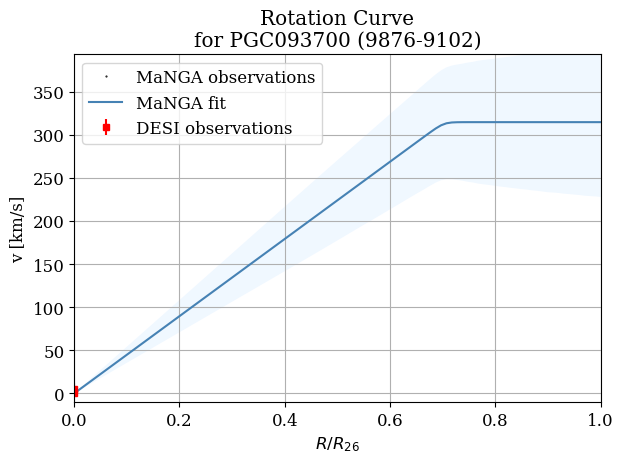

In [1197]:
fig, ax = plt.subplots(1,1, tight_layout=True)

ax.fill_between(r, 
                Velocity_curve-stdevs, 
                Velocity_curve+stdevs, 
                facecolor='aliceblue')

ax.plot(rm_deproj, np.abs(vm_deproj), 'k.', markersize=1, label='MaNGA observations')

ax.plot(r, Velocity_curve, c='steelblue', label='MaNGA fit')

ax.errorbar(gal_PV_obs_good['SKY_FIBER_DIST_R26'], 
            gal_PV_obs_good['V'], 
            yerr=gal_PV_obs_good['VERR'], 
            fmt='rs', 
            markersize=5, 
            label='DESI observations')

plot_title = 'Rotation Curve\nfor {gname}'.format(gname = str(SGA_info['GALAXY'][0])) + ' (' + gal_id + ')'

ax.set(xlabel='$R/R_{26}$', 
       ylabel='v [km/s]', 
       xlim=(0,1), 
       ylim=(-10, 1.25*np.max([V_max, np.max(np.abs(gal_PV_obs_good['V']))])), 
       title=plot_title)

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), fontsize=12)#, loc='lower right')

ax.grid(visible=True)

plt.savefig('../Figures/' + gal_id + '_rot_curve.png', format='png', dpi=150);

### Create data file for DESI publication

We just need to save the ($x$, $y$) values of all the data shown in the figure.

#### MaNGA data points

In [542]:
plot_data_radius = fits.Column(name='radius', array=rm_deproj.compressed(), format='E', unit='R26')
plot_data_velocity = fits.Column(name='velocity', array=vm_deproj.compressed(), format='E', unit='km/s')

plot_data_table = fits.BinTableHDU.from_columns([plot_data_radius, plot_data_velocity])

#### MaNGA fit

In [543]:
plot_fit_radius = fits.Column(name='radius', array=r, format='E', unit='R26')
plot_fit_velocity = fits.Column(name='velocity', array=Velocity_curve, format='E', unit='km/s')
plot_fit_sigma = fits.Column(name='sigma_v', array=stdevs, format='E', unit='km/s')

plot_fit_table = fits.BinTableHDU.from_columns([plot_fit_radius, plot_fit_velocity, plot_fit_sigma])

#### DESI data points

In [544]:
plot_DESI_radius = fits.Column(name='radius', array=gal_PV_obs_good['SKY_FIBER_DIST_R26'], format='E', unit='R26')
plot_DESI_velocity = fits.Column(name='velocity', array=gal_PV_obs_good['V'], format='E', unit='km/s')
plot_DESI_sigma = fits.Column(name='sigma_v', array=gal_PV_obs_good['VERR'], format='E', unit='km/s')

plot_DESI_table = fits.BinTableHDU.from_columns([plot_DESI_radius, plot_DESI_velocity, plot_DESI_sigma])

In [545]:
hdr = fits.Header()
hdr['TAB1'] = 'SDSS MaNGA DR16'
hdr['TAB2'] = 'fit to SDSS MaNGA DR16 data'
hdr['TAB3'] = 'DESI fuji'
empty_primary = fits.PrimaryHDU(header=hdr)

hdul = fits.HDUList([empty_primary, plot_data_table, plot_fit_table, plot_DESI_table])

hdul.writeto('publication_data/fig9.fits', overwrite=True)

## Legacy Survey image cutout

In [546]:
def get_cutout(sga_id, ra, dec, size, verbose=False):
    '''
    Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    sga_id : int
        SGA_ID
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    '''
    # Either load an existing image or download a cutout.
    img_name = 'cache/{}.jpg'.format(sga_id)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/660359.jpg exists.


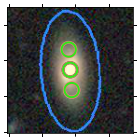

In [27]:
# Padd the image cutout of the galaxy
npix = np.minimum(int(1.025 * 2*r26.value*60/0.262), 512)

# Download image file
img_file, wcs = get_cutout(sga_id, SGA_info['RA'][0], SGA_info['DEC'][0], size=npix, verbose=True)
img = mpl.image.imread(img_file)

fig = plt.figure(figsize=(3.5,2.5))

ax = fig.add_subplot(111, projection=wcs)
ax.imshow(np.flip(img, axis=0))
#ax.set(xlabel='ra', ylabel='dec')
'''
ax.text(int(0.02*npix), 
        int(0.85*npix), 
        'SGA: {}\nMaNGA: {}\n$z={{{:.4f}}}$'.format(sga_id, gal_id, z_center), 
        fontsize=12, 
        color='yellow')
''';
#overlay = ax.get_coords_overlay('icrs')
#overlay.grid(color='white', ls='dotted');

# Add the location of the SDSS and DESI fibers.
# SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
r1_c = SphericalCircle((SGA_info['RA'][0] * u.deg, SGA_info['DEC'][0] * u.deg), 2 * u.arcsec,
                     edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                     transform=ax.get_transform('icrs'))
r2_c = SphericalCircle((SGA_info['RA'][0] * u.deg, SGA_info['DEC'][0] * u.deg), 2 * u.arcsec,
                     edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                     transform=ax.get_transform('icrs'))
ax.add_patch(r1_c)
ax.add_patch(r2_c)

for tft in gal_PV_obs_good:
    if tft['SKY_FIBER_DIST_R26'] < 0.4:
        #ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])
        ra, dec = float(tft['RA']), float(tft['DEC'])

        # Add the location of the SDSS and DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor='lime', facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)

fig.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)

ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

#fig.savefig('../Figures/{}_cutout.eps'.format(gal_id), format='eps', dpi=120)
#fig.savefig('../Figures/{}_cutout.png'.format(gal_id), dpi=120)

## Combine all figures

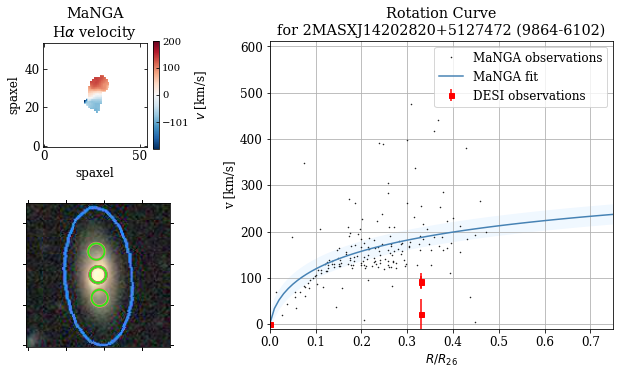

In [29]:
fig = plt.figure(figsize=(9,5))

####################################################################################
# MaNGA H-alpha velocity map
#-----------------------------------------------------------------------------------
ax1 = fig.add_axes([0.1, 0.6, 0.2, 0.3])

#plot_Ha_vel(mHa_vel, gal_id, ax=ax1)

minimum = ma.min(mHa_vel)
maximum = ma.max(mHa_vel)
if minimum > 0:
    vmax_bound = maximum
    vmin_bound = 0
else:
    vmax_bound = ma.max([np.abs(minimum), np.abs(maximum)])
    vmin_bound = -vmax_bound
cbar_ticks = np.linspace(vmin_bound, vmax_bound, 5, dtype='int')

ax1.set_title('MaNGA\n' + r'H$\alpha$ velocity')
Ha_vel_im = ax1.imshow(mHa_vel, 
                       cmap='RdBu_r', 
                       origin='lower', 
                       vmin=vmin_bound, 
                       vmax=vmax_bound)

cbar = plt.colorbar(Ha_vel_im, ax=ax1, ticks=cbar_ticks)
cbar.ax.tick_params(direction='in', labelsize=10)
cbar.set_label('$v$ [km/s]')

ax1.tick_params(axis='both', direction='in')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.set_xlabel('spaxel')
ax1.set_ylabel('spaxel')
####################################################################################


####################################################################################
# Legacy survey cutout
#-----------------------------------------------------------------------------------
ax2 = fig.add_axes([0.01, 0.05, 0.35, 0.4], projection=wcs)

ax2.imshow(np.flip(img, axis=0))

r1_c = SphericalCircle((SGA_info['RA'][0]*u.deg, SGA_info['DEC'][0]*u.deg), 
                       2*u.arcsec,
                       edgecolor='black', 
                       facecolor='none', 
                       alpha=0.8, 
                       lw=3,
                       transform=ax2.get_transform('icrs'))
r2_c = SphericalCircle((SGA_info['RA'][0]*u.deg, SGA_info['DEC'][0]*u.deg), 
                       2*u.arcsec,
                       edgecolor='red', 
                       facecolor='none', 
                       alpha=0.8, 
                       lw=2,
                       transform=ax2.get_transform('icrs'))
ax2.add_patch(r1_c)
ax2.add_patch(r2_c)

for tft in gal_PV_obs_good:
#    if tft['SKY_FIBER_DIST_R26'] < 0.4:
    #ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])
    ra, dec = float(tft['RA']), float(tft['DEC'])

    # Add the location of the SDSS and DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra*u.deg, dec*u.deg), 
                         2*u.arcsec,
                         edgecolor='lightcoral', 
                         facecolor='none', 
                         alpha=1, 
                         lw=3,
                         transform=ax2.get_transform('icrs'))
    r2 = SphericalCircle((ra*u.deg, dec*u.deg), 
                         2*u.arcsec,
                         edgecolor='lime', 
                         facecolor='none', 
                         alpha=0.8, 
                         lw=2,
                         transform=ax2.get_transform('icrs'))
    ax2.add_patch(r1)
    ax2.add_patch(r2)

ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
####################################################################################


####################################################################################
# Rotation curve
#-----------------------------------------------------------------------------------
ax3 = fig.add_axes([0.45, 0.1, 0.53, 0.8])

ax3.fill_between(r, 
                 Velocity_curve-stdevs, 
                 Velocity_curve+stdevs, 
                 facecolor='aliceblue')

ax3.plot(rm_deproj, np.abs(vm_deproj), 'k.', markersize=1, label='MaNGA observations')

ax3.plot(r, Velocity_curve, c='steelblue', label='MaNGA fit')

ax3.errorbar(gal_PV_obs_good['SKY_FIBER_DIST_R26'], 
             gal_PV_obs_good['V'], 
             yerr=gal_PV_obs_good['VERR'], 
             fmt='rs', 
             markersize=5, 
             label='DESI observations')

plot_title = 'Rotation Curve\nfor {gname}'.format(gname = str(SGA_info['GALAXY'][0])) + ' (' + gal_id + ')'

ax3.set(xlabel='$R/R_{26}$', 
        ylabel='v [km/s]', 
        xlim=(0,0.75), 
        ylim=(-10, 1.25*V_max), 
        title=plot_title)

handles, labels = ax3.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax3.legend(*zip(*unique), fontsize=12)

ax3.grid(visible=True)
####################################################################################

#plt.savefig('../Figures/{}_multi.png'.format(gal_id), dpi=120)
#plt.savefig('../Figures/{}_multi.eps'.format(gal_id), format='eps', dpi=120)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


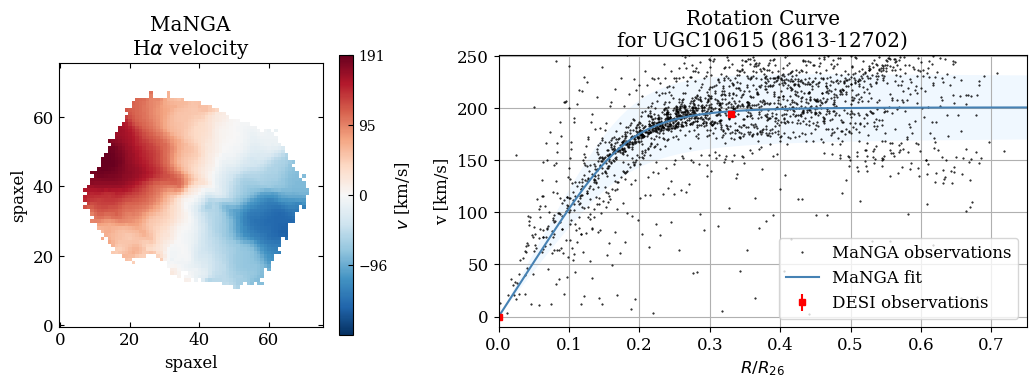

In [552]:
fig = plt.figure(figsize=(11,4))

####################################################################################
# MaNGA H-alpha velocity map
#-----------------------------------------------------------------------------------
ax1 = fig.add_axes([0.1, 0.1, 0.3, 0.7])

#plot_Ha_vel(mHa_vel, gal_id, ax=ax1)

minimum = ma.min(mHa_vel)
maximum = ma.max(mHa_vel)
if minimum > 0:
    vmax_bound = maximum
    vmin_bound = 0
else:
    vmax_bound = ma.max([np.abs(minimum), np.abs(maximum)])
    vmin_bound = -vmax_bound
cbar_ticks = np.linspace(vmin_bound, vmax_bound, 5, dtype='int')

ax1.set_title('MaNGA\n' + r'H$\alpha$ velocity')
Ha_vel_im = ax1.imshow(mHa_vel, 
                       cmap='RdBu_r', 
                       origin='lower', 
                       vmin=vmin_bound, 
                       vmax=vmax_bound)

cbar = plt.colorbar(Ha_vel_im, ax=ax1, ticks=cbar_ticks)
cbar.ax.tick_params(direction='in', labelsize=10)
cbar.set_label('$v$ [km/s]')

ax1.tick_params(axis='both', direction='in')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.set_xlabel('spaxel')
ax1.set_ylabel('spaxel')
####################################################################################


####################################################################################
# Rotation curve
#-----------------------------------------------------------------------------------
ax3 = fig.add_axes([0.5, 0.12, 0.48, 0.68])

ax3.fill_between(r, 
                 Velocity_curve-stdevs, 
                 Velocity_curve+stdevs, 
                 facecolor='aliceblue')

ax3.plot(rm_deproj, np.abs(vm_deproj), 'k.', markersize=1, label='MaNGA observations')

ax3.plot(r, Velocity_curve, c='steelblue', label='MaNGA fit')

ax3.errorbar(gal_PV_obs_good['SKY_FIBER_DIST_R26'], 
             gal_PV_obs_good['V'], 
             yerr=gal_PV_obs_good['VERR'], 
             fmt='rs', 
             markersize=5, 
             label='DESI observations')

plot_title = 'Rotation Curve\nfor {gname}'.format(gname = str(SGA_info['GALAXY'][0])) + ' (' + gal_id + ')'

ax3.set(xlabel='$R/R_{26}$', 
        ylabel='v [km/s]', 
        xlim=(0,0.75), 
        ylim=(-10, 1.25*V_max), 
        title=plot_title)

handles, labels = ax3.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax3.legend(*zip(*unique), fontsize=12)

ax3.grid(visible=True)
####################################################################################

#plt.savefig('../Figures/{}_multi.png'.format(gal_id), dpi=120)
plt.savefig('../Figures/{}_multi.eps'.format(gal_id), format='eps', dpi=120)